# Environment Setting(Package & multiprocessing)

In [14]:
# Anal Env.
import pandas as pd
import numpy  as np
import os
import re
import datetime
import pytz
import copy
from collections import Counter
from emoji       import UNICODE_EMOJI
from functools   import reduce
import sys
sys.path.append('/home/handeully/')
import bigquery_etl as bq
import operator
import time

# NLP Env.
import nltk
from nltk import FreqDist
from nltk.corpus   import stopwords
from nltk.tokenize import regexp_tokenize
from nltk.stem     import WordNetLemmatizer,PorterStemmer,LancasterStemmer
from nltk.corpus   import wordnet
from nltk.corpus   import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag

# stop_words = stopwords.words('english')
import spacy
import gensim
from gensim import corpora
from gensim.models.keyedvectors import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import ray
import psutil
from tqdm.notebook import tqdm

#glove
from glove import Corpus, Glove

# Vis Env.
import pyLDAvis
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# GCP Env.
import google.auth
from google.cloud import bigquery
from googletrans import Translator
from google_trans_new import google_translator

# Coding Env.
import warnings
credentials, project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

client = bigquery.Client(credentials=credentials, project=project_id )
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
warnings.filterwarnings("ignore")

#initialization ray
num_logit_cpus = psutil.cpu_count()
print(f'multiprocessing using {num_logit_cpus} cores')
ray.init(ignore_reinit_error=True,num_cpus=num_logit_cpus)
# ray.shutdown()

multiprocessing using 16 cores


2021-06-27 12:48:10,848	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '10.178.0.34',
 'raylet_ip_address': '10.178.0.34',
 'redis_address': '10.178.0.34:6379',
 'object_store_address': '/tmp/ray/session_2021-06-27_12-48-10_297644_4164802/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-06-27_12-48-10_297644_4164802/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-06-27_12-48-10_297644_4164802',
 'metrics_export_port': 63089,
 'node_id': '1382d9c85df133c02764f601c176aafe85e99790839a4ec9a39407f4'}

# Define List

In [22]:
# Load Data "FROM" Big Query(db connection)
def convert_lowercase(df):
    df_1 =  df.apply(lambda x: x.astype(str).str.lower() if(x.dtype == 'object') else x)
    return df_1

def convert_uppercase(df):
    upper_list = ['reviewId','asin','sku','size','cmpl_fc1_cd']
    cols = list(set(upper_list)& set(df.columns))
    df[cols] = df[cols].apply(lambda x: x.astype(str).str.upper() if(x.dtype == 'object') else x)
    return df

def top20_df_brand(df):
    br_cat_rvw_rank  = pd.pivot_table(df, index = ['brand'], values = ['reviewId'], columns = ['prdct_ctgry_4_5'], aggfunc = ['count'], fill_value = 0, margins = True)#.reset_index()#.to_csv('ddd.csv')
    br_rvw_rank_all  = br_cat_rvw_rank['count']['reviewId']['All'].reset_index()
    br_rvw_rank_all  = br_rvw_rank_all.loc[(br_rvw_rank_all['brand'] != 'All'),]
    br_rvw_rank_all['rank'] = br_rvw_rank_all['All'].rank(ascending=False).astype(int)
    br_rvw_rank_all  = br_rvw_rank_all.sort_values(by='rank',ascending=True)
    br_rvw_rank_all  = br_rvw_rank_all[0:20]
    return br_rvw_rank_all['brand'].tolist()

def tokenized_sents(df):
    corpus = []
    for i,v in enumerate(neg_df['review_text']):
        if v is None:
            print(i)
        else :
            for j in pos_tag(regexp_tokenize(v.lower(),"[\w']+")) :
                if (j[1] in Y_POS_TAG ) & (len(j[0])>1):
                    corpus.append(j)
    return corpus

#check multiprocessing progress 
def to_iterator(obj_ids):
    while obj_ids:
        done, obj_ids = ray.wait(obj_ids)
        yield ray.get(done[0])
        

def to_feather_df(df,name):
    df.reset_index().to_feather(f'temp/{name}.ftr')
    print(f'temp/{name}.ftr에 저장완료')

#  Data Load

In [9]:
review_sql = f'''
                WITH base_table AS (SELECT A.*,B.prdct_ctgry_4_5,B.brand,RANK() OVER(partition by A.reviewId order by crawlTime desc) as rank
                                    FROM `market-analysis-project-91130`.crwl.amz_rvw_all A 
                                    LEFT JOIN `market-analysis-project-91130`.meta.crwl_amz_pdt_mst_all B ON A.asin =B.asin)
                SELECT  A.reviewId,
                        A.region,		
                        A.brand as original_brand,
                        b.brand as map_ori_brand,
                        CASE WHEN lower(b.brand_adj) IS NOT NULL
                             THEN lower(b.brand_adj)
                             ELSE lower(A.brand)
                             END as brand,
                        b.brand_adj_rank  as  brand_rank,
                        C.category_rev,
                        C.subcategory_1_rev,
                        C.subcategory_2_rev,
                        C.inch_from_title_rev,
                        C.inch_from_titleDesc_rev,
                        A.asin,
                        date(A.date)as date,
                        A.helpful_vote,
                        A.initialTime,
                        A.rating,
                        A.reviewer_url,
                        A.product_option,
                        A.title,
                        A.verified_purchase,
                        A.crawlTime,
                        lower(A.review_text) as review_text,
                        A.prdct_ctgry_4_5 as category
                FROM base_table A 
                LEFT JOIN rvw_mst.bsr_top10_brand  b on lower(A.brand) = lower(b.brand)  and lower(A.prdct_ctgry_4_5) = lower(b.bsr_ctgry) and b.chnnl_nm ='US AMZ'
                LEFT JOIN rvw_mst.amz_ttl_asin_list_2105_asin_flag C ON A.asin=C.asin AND C.prdct_title IS NOT NULL
                WHERE A.prdct_ctgry_4_5 IN ('Beds','Bed Frames','Mattresses','Box Springs','Sofas & Couches','Mattress Toppers')
                and rank = 1
                AND A.reviewId not in (select reviewId
                                          from (
                                                 SELECT reviewId,count(DISTINCT prdct_ctgry_4_5)--A.*,B.prdct_ctgry_4_5,RANK() OVER(partition by A.reviewId order by crawlTime desc) as rank
                                                 FROM base_table
                                                 GROUP BY reviewId 
                                                 HAVING count(DISTINCT prdct_ctgry_4_5) > 1
                                             )
                                     )		
                AND substring(A.date,1,4) >= '2021'
                and A.rating in(1,2,5)
                and A.brand is not null
                order by brand,A.prdct_ctgry_4_5,reviewId,date 
             '''

filter_sql = f''' 
                SELECT distinct stopword 
                FROM market-analysis-project-91130.taxonomy.stp_wds;
              '''

compl_factor_sql = '''
                    SELECT a.cmpl_fc1,a.cmpl_fc1_cd,b.cmpl_fc2,c.synonym,c.lemma
                    FROM market-analysis-project-91130.taxonomy.cpl_fc1 a 
                    FULL OUTER JOIN market-analysis-project-91130.taxonomy.cpl_fc2 b   on lower(a.cmpl_fc1_cd) = lower(b.cmpl_fc1_cd)
                    FULL OUTER JOIN market-analysis-project-91130.taxonomy.rvw_kyw_syn c on lower(b.cmpl_fc2) = lower(c.cmpl_fc2) 
                    '''

shiny_factor_sql = '''
                    SELECT *
                    FROM taxonomy.shn_kwd
                    '''

bsr_brand_sql = '''
                SELECT DISTINCT *
                FROM (
                    SELECT
                        t1.category as prdct_ctgry_4_5 ,
                        LOWER(t1.brand) as brand ,
                        t1.rank ,
                        CASE
                            WHEN t2.brand_adj IS NOT NULL THEN lower(t2.brand_adj)
                            ELSE lower(t1.brand)
                        END AS brand_adj
                    FROM
                        (
                        SELECT
                            bsr_ctgry as Category,
                            lower(brand) as brand,
                            min(brand_adj_rank) as rank
                        FROM
                            rvw_mst.bsr_top10_brand
                        WHERE
                            bsr_ctgry IN ("Beds","Bed Frames","Mattresses","Box Springs","Sofas & Couches","Mattress Toppers")
                        GROUP BY
                            bsr_ctgry,
                            lower(brand) ) t1
                    LEFT JOIN `market-analysis-project-91130`.meta.brand_mapping t2 on
                        t1.brand = lower(t2.brand)
                )
                ORDER BY
                        1,
                        3

              '''

part_sql = '''
              SELECT *
              FROM market-analysis-project-91130.taxonomy.prt_wds
           '''

In [1926]:
# df_1             = convert_lowercase(bq.select_query(review_sql))

# review Data & stop words & bsr data

In [10]:
bsr_brand_df   = convert_lowercase(bq.select_query(bsr_brand_sql))
df             = convert_lowercase(bq.select_query(review_sql))
df['rat_sentiment'] =  np.where(df['rating']<=2, 0,1) ## give rating sentiment 1~2 star = neg /  5 star = pos
# Amazon review top 20 brand + Best Seller Brand each category 
stopword_df    = convert_lowercase(bq.select_query(filter_sql))
parts_df       = convert_lowercase(bq.select_query(part_sql))
stop_words     = stopword_df['stopword'].tolist()+parts_df.part_word.tolist()
print('\n--> filtering top 20 brand & rating score 1~2 (neg)/ 5(pos) : ',df.shape)
print('stop_words         : ' ,len(stop_words))
print('bsr_brand_sql      : ' ,bsr_brand_df.shape)
print('parts_df           : ' ,parts_df.shape)


--> filtering top 20 brand & rating score 1~2 (neg)/ 5(pos) :  (117922, 24)
stop_words         :  634
bsr_brand_sql      :  (193, 4)
parts_df           :  (88, 1)


In [13]:
# (Step1-1) data filtering  
def make_anal_df(df,senti):
    # sentiment (0) : negative review | (1) : positive review
    if senti == 0:
        df_1 = df[(df['rat_sentiment']==0)&(~df['title'].isnull())&(~df['review_text'].isnull())]
    else :
        df_1 = df[(df['rat_sentiment']==1)&(~df['title'].isnull())&(~df['review_text'].isnull())]
    df_1.loc[(~df_1['title'].isnull()) & (df_1['review_text'].isnull()),'review_text'] = df_1.title
    df_1['date']      = pd.to_datetime(df_1.date)
    df_1['yearmonth'] = df_1['date'].dt.strftime('%Y%m')
    df_1['year']      = df_1['date'].dt.strftime('%Y')
    df_1['month']     = df_1['date'].dt.strftime('%m')
    df_1['date']      = df_1['date'].astype(str)
    return df_1

neg_df = make_anal_df(df,0)
pos_df = make_anal_df(df,1)
all_df = pd.concat([neg_df,pos_df])
# all_df.reset_index().to_feather('temp/all_review_df_0426.ftr')
print(f'rating(1~2) negative review : {neg_df.shape}')
print(f'rating(5) positive review : {pos_df.shape}')
print(f'all reviews : {all_df.shape}')

rating(1~2) negative review : (26997, 27)
rating(5) positive review : (90925, 27)
all reviews : (117922, 27)


In [29]:
# pos_df

# Complain Fator 

In [6]:
cpl_factor    = convert_lowercase(bq.select_query(compl_factor_sql))
shiny_factor = convert_lowercase(bq.select_query(shiny_factor_sql))
cmpl_fc_list  = list(set(cpl_factor['cmpl_fc1'].unique().tolist())|set(cpl_factor['cmpl_fc2'].unique().tolist())|set(cpl_factor['synonym'].unique().tolist())|set(cpl_factor['lemma'].unique().tolist())|set(shiny_factor['keyword']))
multi_express = list(filter(lambda x: len(x.split(' '))>1 , cmpl_fc_list))
# Put this list for MWE Tokenizing
mwe = [tuple(f.split(' ')) for f in multi_express]
print('complain factor    : ' ,cpl_factor.shape)
print('shiyne factor    : ' ,shiny_factor.shape)
print(f'all complain factor list  : {len(cmpl_fc_list)}')
print(f'multi_express lenth : {len(mwe)}')

complain factor    :  (1195, 5)
shiyne factor    :  (165, 2)
all complain factor list  : 1237
multi_express lenth : 565


# Data Preprocessing 

## Step 1) Tokenized 

In [15]:
@ray.remote
def reviewId_tokenized_sents(df,cat):
    N_POS_TAG   = ['CC','CD','DT','EX','FW','LS','PDT','POS','PRP','PRP$','TO','WDT','WP','WRB']
    Y_POS_TAG   = ['JJ','JJR','JJS','MD','IN','NN','NNS','NNP','NNPS','RB','RBR','RBS','RP','UH','VB','VBG','VBD','VBN','VBP','VBZ']
    keyword_df2 = pd.DataFrame(columns=['word','count','reviewId','asin'])
    mwe_tokenizer          = nltk.tokenize.MWETokenizer(mwe,separator=' ')
    for i,v in enumerate(df['review_text']):
        corpus = []
        reid = str(df.iloc[i].reviewId)
        asin = str(df.iloc[i].asin)
        for j in pos_tag(regexp_tokenize(v,"[\w']+")) :
            if (j[1] in Y_POS_TAG ) & (len(j[0])>1) & (j[0].isascii()):
                    corpus.append(j[0])
            tokenized_string       = mwe_tokenizer.tokenize(corpus)
            word_df    = pd.DataFrame(tokenized_string,columns=['word'])
            keyword_df = pd.DataFrame.from_dict(Counter(word_df['word']), orient='index').reset_index()
            keyword_df['reviewId'] = reid
            keyword_df['asin'] = asin
            if keyword_df.shape[0] > 0:
                keyword_df.columns = ['word','count','reviewId','asin']    
        keyword_df2    = pd.concat([keyword_df2,keyword_df])
        keyword_df2    = keyword_df2[~keyword_df2['word'].isin(stop_words)].sort_values(by='reviewId',ascending=False)
    keyword_df2['yearmonth']  = cat
    return keyword_df2

all_keyword_df  = [reviewId_tokenized_sents.remote(all_df.loc[(all_df['yearmonth']==j)],j) for j in tqdm(all_df['yearmonth'].unique()) ]
for x in tqdm(to_iterator(all_keyword_df), total=len(all_keyword_df)):
    pass
all_keyword_df  = pd.concat(ray.get(all_keyword_df))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

# Glove

In [604]:
def tokenized_sents(df):
    corpus = []
    try:
        for i,v in enumerate(tqdm(df['review_text'])):
    #         print(f' index : {i}| text : {v}\n')
            word = []
            for j in pos_tag(regexp_tokenize(v,"[\w']+")) :
                if (j[1] in Y_POS_TAG ) & (len(j[0])>1) &  (j[0] not in stop_words+parts_df.part_word.tolist()) & (j[0].isascii()):
                    word.append(j[0])
            mwe_tokenizer          = nltk.tokenize.MWETokenizer(mwe,separator=' ')
            tokenized_string       = mwe_tokenizer.tokenize(word)
            corpus.append(tokenized_string)
    except : 
        pass
    return corpus

## if you wonder that nltk pos tag
# nltk.help.upenn_tagset()
# N_POS_TAG  = ['CC','CD','DT','EX','FW','IN','LS','PDT','POS','PRP','PRP$','TO','WDT','WP','WRB']
# Y_POS_TAG  = ['JJ','JJR','JJS','MD','NN','NNS','NNP','NNPS','RB','RBR','RBS','RP','UH','VB','VBG','VBD','VBN','VBP','VBZ']

# corpus_list = tokenized_sents(neg_df)


# corpus = Corpus() 
# corpus.fit(corpus_list, window=5)

# glove = Glove(no_components=100, learning_rate=0.05)
# glove.fit(corpus.matrix, epochs=20, no_threads=4, verbose=True)
# glove.add_dictionary(corpus.dictionary)

# glove.similar_by_vector('odor', topn=100, restrict_vocab=None)
# glove.most_similar("odor")

array([[ 1.55760658e-01,  9.32956284e-02, -2.29402243e-02, ...,
        -3.05967819e-03, -1.02890003e-01,  1.64814734e-01],
       [ 3.04232260e-01,  1.61990663e-01, -7.34701318e-02, ...,
        -4.73683322e-02,  2.65600176e-01,  1.51605458e-01],
       [ 5.84734698e-02,  2.64750834e-01, -9.52077816e-02, ...,
         2.23433312e-01,  9.95656291e-02, -1.22691695e-01],
       ...,
       [-3.37672695e-03, -3.20836021e-03, -3.12030466e-04, ...,
         1.05309040e-02, -3.29594434e-03,  5.84436668e-05],
       [-1.52322037e-02, -5.34762392e-03, -1.23144735e-03, ...,
         8.65114611e-03, -1.12655900e-02, -9.97944753e-03],
       [-2.37210877e-03, -3.30636308e-04, -5.34287628e-03, ...,
        -8.50548406e-05, -7.04198608e-04,  8.20526769e-03]])

# ■==== EU Review ====

In [1238]:

@ray.remote
def tokenized_review_text(ct,df,senti_cat,prdt_cat):
    # filtierng filtering unnecessary POS tag 
    #n_pos_tag = 15 lists | y_pos_tag = 19 lists
    try:
#         print(f'\nbrand : {br} / category : {prdt_cat} / data shape : {df.shape}')
        df = df[df['rat_sentiment'] == senti_cat ]
        N_POS_TAG  = ['CC','CD','DT','EX','FW','IN','LS','PDT','POS','PRP','PRP$','TO','WDT','WP','WRB']
        Y_POS_TAG  = ['JJ','JJR','JJS','MD','NN','NNS','NNP','NNPS','RB','RBR','RBS','RP','UH','VB','VBG','VBD','VBN','VBP','VBZ']
        tokenized_sents  = [j for i in df['reviews'] for j in pos_tag(regexp_tokenize(i,"[\w']+")) if (j[1] in Y_POS_TAG) & (len(j[0]) > 1) and (j[0].isascii())] 
        tokenized_string = [i[0] for i in tokenized_sents]
        mwe_tokenizer          = nltk.tokenize.MWETokenizer(mwe,separator=' ')
        tokenized_string       = mwe_tokenizer.tokenize(tokenized_string)
        word_df                = pd.DataFrame(tokenized_string,columns=['word'])
        counter_df             = pd.DataFrame.from_dict(Counter(word_df['word']), orient='index').reset_index()
        counter_df.columns     = ['word','count']
        counter_df             = counter_df[~counter_df['word'].isin(stop_words)].sort_values(by='count',ascending=False)
        counter_df['brand']    = 'ZINUS'
        counter_df['country']  = ct
        counter_df['category'] = prdt_cat
        if senti_cat == 0 :
            counter_df['sentiment'] = 'negative'
        else: 
            counter_df['sentiment'] = 'positive'
        counter_df          = counter_df.reindex(columns=['brand','country','category','word','count','sentiment'])
    #     counter_df          = counter_df.reindex(columns=['brand','word','count','sentiment'])
        return counter_df
    except :
        pass
    
# (Step1-1) data filtering  
def make_anal_df(df,senti):
    # sentiment (0) : negative review | (1) : positive review
    if senti == 0:
        df_1 = df[(df['rat_sentiment']==0)&(~df['title'].isnull())&(~df['reviews'].isnull())]
    else :
        df_1 = df[(df['rat_sentiment']==1)&(~df['title'].isnull())&(~df['reviews'].isnull())]
    df_1.loc[(~df_1['title'].isnull()) & (df_1['reviews'].isnull()),'reviews'] = df_1.title
    return df_1

# (Step1-2) make summary table
def eu_cal_keyword_rt(keyword_df):
    # remove puntuation in word 
    keyword_df['word'] = keyword_df['word'].str.replace('[^\w\s]','',regex= True)
    # join all each word count in category
    br_cat_keyword_df  = keyword_df.groupby(['category','word'])['count'].sum().reset_index()
    br_cat_keyword_df.columns = ['category','word','cat_word_cnt']
    df_1                      = pd.merge(keyword_df,br_cat_keyword_df[['category','word','cat_word_cnt']],how='left',left_on = ['category','word'],right_on = ['category','word'])
    df_1['cat_word_diff']      = (df_1['count'] / df_1['cat_word_cnt'])*100
    # join all count in category
    all_keyword_sum           = br_cat_keyword_df.groupby(['category'])['cat_word_cnt'].sum().reset_index()
    all_keyword_sum.columns   = ['category','cat_all_word_cnt']
    df_1                      = pd.merge(df_1,all_keyword_sum,how='left',on = ['category'])
    df_1['cat_all_word_diff'] = (df_1['cat_word_cnt'] / df_1['cat_all_word_cnt'])*100
    # join all count in each Country 
    country_keyword_df            =  keyword_df.groupby(['country'])['count'].sum().reset_index()
    country_keyword_df.columns    = ['country','country_all_count']
    df_1                     = pd.merge(df_1,country_keyword_df,how='left',on = ['country'])
    # map cmpl_factor
    cmpl_fc_df = pd.DataFrame(cmpl_fc_list,columns=['cmpl_factor'])
    df_1 = pd.merge(df_1,cmpl_fc_df,how='left',left_on = ['word'],right_on=['cmpl_factor'])
    
    return df_1
    
eu_sql = '''
            SELECT country_code,DATE(DATE) AS date,category,sku,product_description,rating,title,reviews,(a.order) as ss
            FROM `market-analysis-project-91130`.crwl.amz_eu_rvw_all a 
            WHERE rating in(1,2,5)
         '''
eu_df = convert_lowercase(bq.select_query(eu_sql))
eu_df['rat_sentiment'] =  np.where(eu_df['rating']<=2, 0,1)
print(f'EU Data Frame shape : {eu_df.shape}')

eu_neg_df = make_anal_df(eu_df,0)
eu_pos_df = make_anal_df(eu_df,1)
print(f'rating(1~2) negative review : {eu_neg_df.shape}')
print(f'rating(5) positive review : {eu_pos_df.shape}')

eu_neg_keyword  = [tokenized_review_text.remote(j,eu_neg_df[(eu_neg_df['category'] == i)&(eu_neg_df['country_code'] == j)],0,i) for i in tqdm(eu_neg_df['category'].unique()) for j in eu_neg_df['country_code'].unique()]
for x in tqdm(to_iterator(eu_neg_keyword), total=len(eu_neg_keyword)):
    pass
eu_neg_keyword  = pd.concat(ray.get(eu_neg_keyword))

eu_pos_keyword  = [tokenized_review_text.remote(j,eu_pos_df[(eu_pos_df['category'] == i)&(eu_pos_df['country_code'] == j)],1,i) for i in tqdm(eu_pos_df['category'].unique()) for j in eu_pos_df['country_code'].unique()]
for x in tqdm(to_iterator(eu_pos_keyword), total=len(eu_pos_keyword)):
    pass
eu_pos_keyword = pd.concat(ray.get(eu_pos_keyword))

dd = pd.concat([eu_neg_keyword,eu_pos_keyword])

eu_test = eu_cal_keyword_rt(dd)
eu_test = eu_test.round(2)
eu_test = eu_test[~eu_test['word'].isin(stop_words)]

In [1240]:
# def eu_neg_review_index_text(word,country):
#     review_len = len(eu_neg_df.index[(eu_neg_df['reviews'].str.contains(word,regex=True))&(eu_neg_df['country'] == country)].tolist())
#     return review_len

# print(eu_neg_df[eu_neg_df.index.isin([155])])
# eu_neg_df[eu_neg_df.index.isin([155])].reviews.tolist()


,brand,country,category,word,count,sentiment,cat_word_cnt,cat_word_diff,cat_all_word_cnt,cat_all_word_diff,country_all_count,cmpl_factor
0,ZINUS,de,toppers,pressure,2,negative,3,66.67,1969,0.15,5156,NaN
1,ZINUS,de,toppers,relief,2,negative,2,100.00,1969,0.10,5156,NaN
2,ZINUS,de,toppers,hard,1,negative,12,8.33,1969,0.61,5156,NaN
3,ZINUS,de,toppers,felt,1,negative,2,50.00,1969,0.10,5156,NaN
4,ZINUS,de,toppers,lbs,1,negative,1,100.00,1969,0.05,5156,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
13338,ZINUS,es,spring mattresses/sets,bought,1,positive,10,10.00,1830,0.55,4996,NaN
13339,ZINUS,es,spring mattresses/sets,comes,1,positive,3,33.33,1830,0.16,4996,NaN
13340,ZINUS,es,spring mattresses/sets,worry,1,positive,1,100.00,1830,0.05,4996,NaN
13341,ZINUS,es,spring mattresses/sets,grows,1,positive,1,100.00,1830,0.05,4996,NaN


# find text include keyword

In [1612]:
def eu_find_review_index(keyword_df,df,cat):
    all_df = pd.DataFrame(columns=['country','word','review_count','sentiment','all_review_cnt'])
    for country in tqdm(df.country_code.unique()):
        kw = []
        rv = []
        ct = []
        al_rv = []
        cot = []
        df_1 = df[(df['country_code'] == country)]
        for j in df_1.category.unique():
            df_2 = df_1[(df_1['category'] == j)]
            all_review_len = df_2.shape[0]
            print(f'country : {country} / category : {j}/ df : {df_2.shape}')
            for i in keyword_df[(keyword_df['country']==country)&(keyword_df['category']==j)].groupby(['word'])['count'].sum().reset_index().word:
                w = i
                review_len  = len(df_2.index[(df_2['reviews'].str.contains(w,regex=True))].tolist())
                index_list  = df_2.index[(df_2['reviews'].str.contains(w,regex=True))].tolist()
                sku_list    = df_2.loc[df_2.index.isin(index_list),['country_code','sku','category']]
#                 print(f'word : {i} / index : {index_list} / sku_list: {sku_list}')
                kw.append(i)
                rv.append(review_len)
                ct.append(j)
                al_rv.append(all_review_len)
                cot.append(country)
                review_count = pd.DataFrame({ 'country':cot,
                                              'category':ct,
                                              'word' : kw,
                                              'sentiment':cat,
                                              'review_count':rv,                          
                                              'all_review_cnt':al_rv})
    #             if i == 'years':
    #                 print(review_len)
    #                 print(df_1.index[(df_1['reviews'].str.contains(i,regex=True))].tolist())
    #                 print(review_count)
        review_count['review_rate'] = (review_count['review_count']/review_count['all_review_cnt'])*100
        review_count = review_count.round(2)
        all_df_2 = review_count
        all_df = pd.concat([all_df,all_df_2])
    return all_df

eu_neg_review_count = eu_find_review_index(eu_test[eu_test['sentiment']=='negative'],eu_neg_df,'negative')
eu_pos_review_count = eu_find_review_index(eu_test[eu_test['sentiment']=='positive'],eu_pos_df,'positive')
print(eu_neg_review_count.shape)
print(eu_pos_review_count.shape)
eu_word_review_cnt =pd.concat([eu_neg_review_count,eu_pos_review_count])

eu_test_df = pd.merge(eu_test,eu_word_review_cnt,how='left',left_on=['country','category','word','sentiment'],right_on=['country','category','word','sentiment'])
# bq.to_bigquery('crwl.eu_keyword_result',test_df)

In [1613]:
eu_test_df

,brand,country,category,word,count,sentiment,cat_word_cnt,cat_word_diff,cat_all_word_cnt,cat_all_word_diff,country_all_count,cmpl_factor,review_count,all_review_cnt,review_rate
0,ZINUS,de,toppers,pressure,2,negative,3,66.67,1969,0.15,5156,NaN,1,6,16.67
1,ZINUS,de,toppers,relief,2,negative,2,100.00,1969,0.10,5156,NaN,2,6,33.33
2,ZINUS,de,toppers,hard,1,negative,12,8.33,1969,0.61,5156,NaN,1,6,16.67
3,ZINUS,de,toppers,felt,1,negative,2,50.00,1969,0.10,5156,NaN,1,6,16.67
4,ZINUS,de,toppers,lbs,1,negative,1,100.00,1969,0.05,5156,NaN,1,6,16.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13181,ZINUS,es,spring mattresses/sets,bought,1,positive,10,10.00,1830,0.55,4996,NaN,1,33,3.03
13182,ZINUS,es,spring mattresses/sets,comes,1,positive,3,33.33,1830,0.16,4996,NaN,1,33,3.03
13183,ZINUS,es,spring mattresses/sets,worry,1,positive,1,100.00,1830,0.05,4996,NaN,1,33,3.03
13184,ZINUS,es,spring mattresses/sets,grows,1,positive,1,100.00,1830,0.05,4996,NaN,1,33,3.03


# EU - SKU Keyword count

In [1990]:
def find_sku_count(keyword_df,df,senti):
    uk_frame_df1  = pd.DataFrame(columns=['sentiment','all_senti_review_len','country','category','word','word_index','sku','review'])
    cty   = str(keyword_df.country.unique()[0])
    ctg   = str(keyword_df.category.unique()[0])
    senti = senti
    df_len = int(df.shape[0])
    for i in keyword_df.word[0:31]:
        wl       = []
        wd_index = []
        sku_l    = []
        rv_list  = []
        w = ''+i+''
        index_list  = df.index[(df['reviews'].str.contains(w,regex=True))].tolist()
        sku_list    = df.loc[df.index.isin(index_list)].sku.tolist()
        review_list = df.loc[df.index.isin(index_list)].reviews.tolist()
    #     for j in range(0,len(sku_list)):
        for j in range(0,len(sku_list)):
            wl.append(str(i))
            wd_index.append(str(index_list[j]))
            sku_l.append(str(sku_list[j]))
            rv_list.append(str(review_list[j]))
    #         print(f'word : {i} / index : {index_list[j]} / sku : {sku_list[j]}')
        sku_count = pd.DataFrame({ 
                                      'sentiment':senti,
                                      'all_senti_review_len':df_len,
                                      'country':cty,
                                      'category':ctg,
                                      'word':wl,
                                      'word_index':wd_index,
                                      'sku' : sku_l,
                                      'review': rv_list
                                     })
        uk_frame_df2 = sku_count
        uk_frame_df1 = pd.concat([uk_frame_df1,uk_frame_df2])
    return uk_frame_df1

def df_sku_rank(review_df,df_1):
    sku_review_rank = review_df.groupby('sku')['reviews'].count().reset_index().sort_values('reviews',ascending = False)
#     print(sku_review_rank)
    sku_review_rank.columns = ['sku','sku_review_cnt']
    cnt_df         = df_1.groupby(['sku','word'])['word_index'].count().reset_index().sort_values('word_index',ascending = False)
    cnt_df.columns = ['sku','word','sku_word_review_cnt']
    
    result_df = pd.merge(df_1,cnt_df,how='left',on=['sku','word'])
    result_df = pd.merge(result_df,sku_review_rank,how='left',on=['sku'])

    result_df['all_senti_review_len'] = review_df.shape[0]
    result_df['all_country_cat_df_len'] = all_eu_review_df_len
    result_df['senti_review_ratio']     = (result_df['sku_review_cnt']/result_df['all_senti_review_len'])*100
    result_df['sku_word_review_ratio']  = (result_df['sku_word_review_cnt']/result_df['sku_review_cnt'])*100
    result_df[['senti_review_ratio','sku_word_review_ratio']] = result_df[['senti_review_ratio','sku_word_review_ratio']].round(2)
    result_df['sku_word_rank'] = result_df.groupby(['sku','word'])['sku_word_review_ratio'].rank(method = 'first',ascending=False)
    return result_df

eu_country_list  = ['de', 'fr', 'it', 'es']
eu_category = 'frames for mattresses'
eu_sent_set = 'pos'  
# all_eu_review_cnt_df = eu_df[(eu_df['category']==eu_category)].groupby(['country_code']).count()['reviews']
# all_eu_pos_review_cnt_df =eu_pos_df[(eu_pos_df['category']==eu_category)].groupby(['country_code']).count()['reviews']

for i in eu_country_list[3:4] :
    eu_country = i
## positive
    uk_frame_pos_keyword = eu_test_df[(eu_test_df['sentiment']=='positive')&(eu_test_df['country']==eu_country)&(eu_test_df['category']==eu_category)]
    uk_frame_pos_review  = eu_pos_df[(eu_pos_df['country_code'] == eu_country)&(eu_pos_df['category'] == eu_category)]
    uk_frame_pos_result  = find_sku_count(uk_frame_pos_keyword,uk_frame_pos_review,'positive')
    uk_frame_pos_result  = uk_frame_pos_result[~uk_frame_pos_result.word.isin([stop_words])]
    uk_frame_pos_result_1 = df_sku_rank(uk_frame_pos_review,uk_frame_pos_result)
    uk_frame_pos_result_1.to_excel(f'temp/eu_{eu_country}_frame_mattresses.xlsx'    ,index=0)
    uk_frame_pos_result_1.to_excel(f'temp/{eu_country}_frame_{eu_sent_set}_sku.xlsx',index=0)
    
## negative
# uk_frame_neg_keyword = eu_test_df[(eu_test_df['sentiment']=='negative')&(eu_test_df['country']==eu_country)&(eu_test_df['category']==eu_category)]
# uk_frame_neg_review  = eu_neg_df[(eu_neg_df['country_code']==eu_country)&(eu_neg_df['category'] == eu_category)]
# uk_frame_neg_result = find_sku_count(uk_frame_neg_keyword,uk_frame_neg_review,'negative')
# uk_frame_neg_result = uk_frame_neg_result[~uk_frame_neg_result.word.isin([stop_words])]
# uk_frame_neg_result_1 = df_sku_rank(uk_frame_neg_review,uk_frame_neg_result)
# uk_frame_neg_result_1.to_excel(f'temp/eu_{eu_country}_frame_mattresses.xlsx',index=0)


In [815]:
for i,v in enumerate(eu_pos_df[eu_pos_df.index.isin(eu_pos_df.index[(eu_pos_df['reviews'].str.contains('duct',regex=False))].tolist())].reviews):
    print(f'{i} review : {v}\n')

0 review : great product!

1 review : the product looks as it is described.
convenient and great value for money

2 review : it also makes the floor comfortable... really a great product.. fits the body

3 review : i hardly write reviews for a product that already has many, but in this case i will tear up the rule. this topper changed my bed and incredibly improved the quality of rest. i bought the 5cm version, although i was afraid it wasn't enough to make a double bed comfortable than the standard ones and instead i have to think again. i have already recommended this topper to some friends. 5 stars you deserve!

4 review : great product

5 review : the product has arrived in perfect condition and before the indicated date.
for its price you can not ask for more.. it gives extra comfort to a hard quilt and especially without any bad smell that some complain about.
very happy with the purchase and recommended for anyone who wants something economical and comfortable.

6 review : the f

In [1789]:
cc = 'platform beds'
fur_eu_pos_df = eu_pos_df[eu_pos_df['category']== cc]
fur_eu_pos_df.shape

(263, 10)

In [1790]:
def tokenized_sents(df):
    corpus     = []
    N_POS_TAG  = ['CC','CD','DT','EX','FW','IN','LS','PDT','POS','PRP','PRP$','TO','WDT','WP','WRB']
    Y_POS_TAG  = ['JJ','JJR','JJS','MD','NN','NNS','NNP','NNPS','RB','RBR','RBS','RP','UH','VB','VBG','VBD','VBN','VBP','VBZ']
    for i in  tqdm(df.reviews.tolist()):
        word = []
        for j in pos_tag(regexp_tokenize(i,r"[\w']+")) :
            if (j[1] in Y_POS_TAG ) & (len(j[0])>1) &  (j[0] not in stop_words ) & (j[0].isascii()):
                word.append(j[0])
#         mwe_tokenizer          = nltk.tokenize.MWETokenizer(mwe,separator=' ')
#         tokenized_string       = mwe_tokenizer.tokenize(word)
        if len(word) >= 1:
            corpus.append(word)
        else:
            pass
    return corpus


neg_corpus_list = tokenized_sents(eu_neg_df)
pos_corpus_list = tokenized_sents(fur_eu_pos_df)


# corpus_list
# tokenized_sents  = [j for i in eu_df['reviews'] for j in pos_tag(regexp_tokenize(i,"[\w']+")) if (j[1] in Y_POS_TAG) & (len(j[0]) > 1) and (j[0].isascii())] 
# tokenized_string = [i[0] for i in tokenized_sents]
# mwe_tokenizer          = nltk.tokenize.MWETokenizer(mwe,separator=' ')
# tokenized_string       = mwe_tokenizer.tokenize(tokenized_string)

  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/263 [00:00<?, ?it/s]

In [1738]:
# pos_corpus_list

# EU - Word2Vec

In [1935]:
def train_wv_model(**args):
    # sg '0' : CBOW / '1' : Skip-gram 
    model = Word2Vec(sentences=args['corpus'], window=args['window'], min_count=5, workers=args['cores'], sg=args['sg'])
    return model

def save_model(model,filename):
    path ='model/'
    model.wv.save_word2vec_format(path+filename) # 모델 저장
    print(f'{path+filename} saved model is completed.')

def load_model(filename):
    path ='model/'
    model = KeyedVectors.load_word2vec_format(path+filename)
    return model

    
def wv_similar_result(cb_model,sg_model,word,top):
    try:
        cbow = pd.DataFrame(cb_model.similar_by_vector(word, topn=top, restrict_vocab=None),columns=['linked_word','similarity'])
        cbow['word'] = word
        cbow['model'] = 'CBOW'
        cbow['rank'] = cbow['similarity'].rank(method='first',ascending=False)
        cbow = cbow.reindex(columns=['model','word','linked_word','similarity','rank'])
        
        skip_gram = pd.DataFrame(sg_model.similar_by_vector(word, topn=top, restrict_vocab=None),columns=['linked_word','similarity'])
        skip_gram['word'] = word
        skip_gram['model'] = 'Skip-gram'
        skip_gram['rank'] = skip_gram['similarity'].rank(method='first',ascending=False)
        skip_gram = skip_gram.reindex(columns=['model','word','linked_word','similarity','rank'])
#         model_df = pd.concat([cbow,skip_gram],axi)
        model_df = pd.merge(cbow,skip_gram,how='inner',on=['word','rank'])
    
        model_df = model_df.reindex(columns=['word','rank','linked_word_x','similarity_x','linked_word_y','similarity_y'])
        model_df.columns = ['WORD','RANK','CBOW_WORDS','CB_SIMILARITY','SG_WORDS','SG_SIMILARITY']
#         print(f'■[cbow] \ncomplaing Factor : {word}\n linked keyword : {all_wv_model.similar_by_vector(word, topn=top, restrict_vocab=None)}')
#         print(f'■[skip_gram]\ncomplaing Factor : {word}\n linked keyword : {sg_wv_model.wv.similar_by_vector(word, topn=top, restrict_vocab=None)}')
#         return cbow_df
#         print(model_df)
        return model_df
    except:
        pass
    
cb_wv_model = train_wv_model(corpus = pos_corpus_list,sg=0,cores = num_logit_cpus,window = 2)
sg_wv_model = train_wv_model(corpus = pos_corpus_list,sg=1,cores = num_logit_cpus,window = 2)

cb_model_name = 'eu_plat_bed_pos_review_cb_model'
sg_model_name = 'eu_plat_bed_pos_review_sg_model'

save_model(cb_wv_model,cb_model_name)
save_model(sg_wv_model,sg_model_name)

neg_cb_wv_model = load_model(cb_model_name)
neg_sg_wv_model = load_model(sg_model_name)
    

model/eu_plat_bed_pos_review_cb_model saved model is completed.
model/eu_plat_bed_pos_review_sg_model saved model is completed.


In [1936]:
fur_top_keyword = eu_test_df[(eu_test_df['sentiment'] == 'positive')&(eu_test_df['category']==cc)].groupby('word')['review_count'].sum().reset_index().sort_values('review_count',ascending=False)
save_df = pd.DataFrame(columns=['WORD','RANK','CBOW_WORDS','CB_SIMILARITY','SG_WORDS','SG_SIMILARITY']) 

for i in fur_top_keyword['word'].unique().tolist()[0:30]:
    print(i)
    s = wv_similar_result(neg_cb_wv_model,neg_sg_wv_model,i,50)
    save_df = pd.concat([save_df,s])
    
save_df['DATA'] = 'positive'
# save_df.to_csv('eu_negative_wv_result.csv',index=0)


easy
assemble
good
quality
recommend
great
price
money
excellent
mount
nice
head
looks
value
solid
end
beautiful
perfect
assembly
buy
happy
simple
sturdy
bought
come
thing
satisfied
box
design
pack


# Word2Vec - Visualization

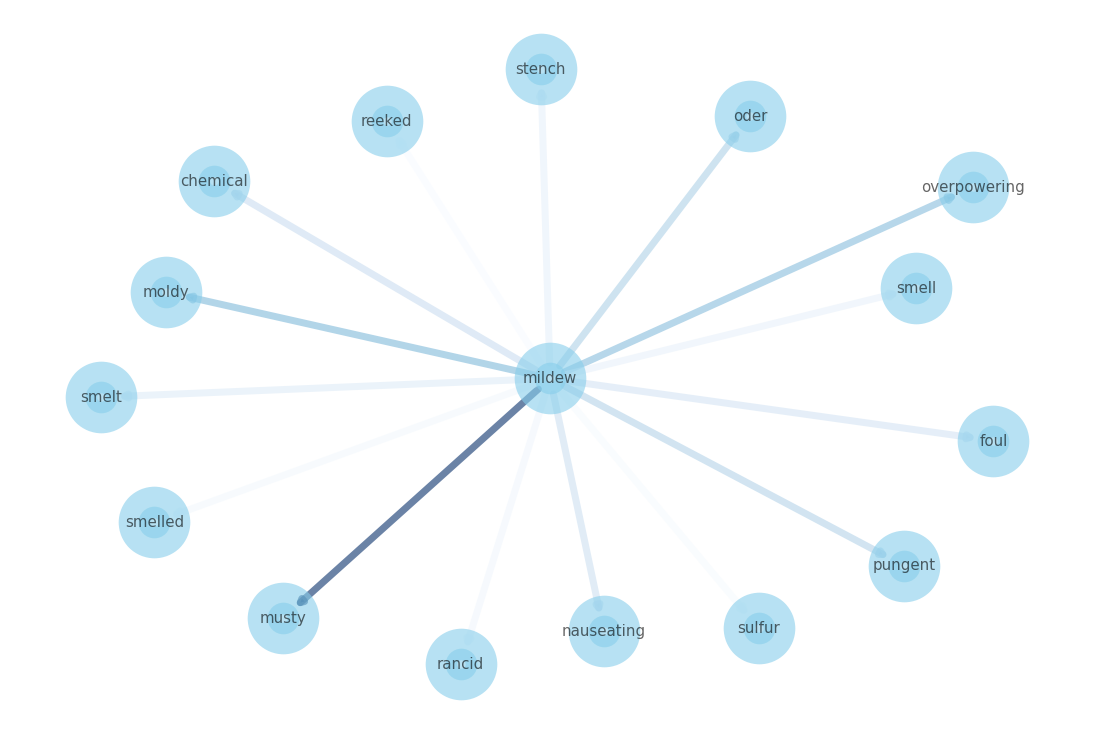

In [8]:
import networkx as nx
# save_df.sort_values(['WORD','SG_SIMILARITY'],ascending=[True,False]).head(100)

save_df = pd.read_excel('temp/word2vec_neg_example.csv')
save_df.head()
plt.figure(figsize=(15, 10))
ss = save_df[save_df['WORD'].isin(['mildew'])].iloc[0:15]
g = nx.from_pandas_edgelist(ss, 'WORD', 'SG_WORDS', create_using = nx.DiGraph())
nx.draw(g, with_labels=True, node_color='skyblue',node_size=1000, alpha=0.6,edge_color=ss['SG_SIMILARITY'], width=7, edge_cmap=plt.cm.Blues,linewidths=40,font_size=15)
# nx.networkx.draw_networkx(g)
plt.show()

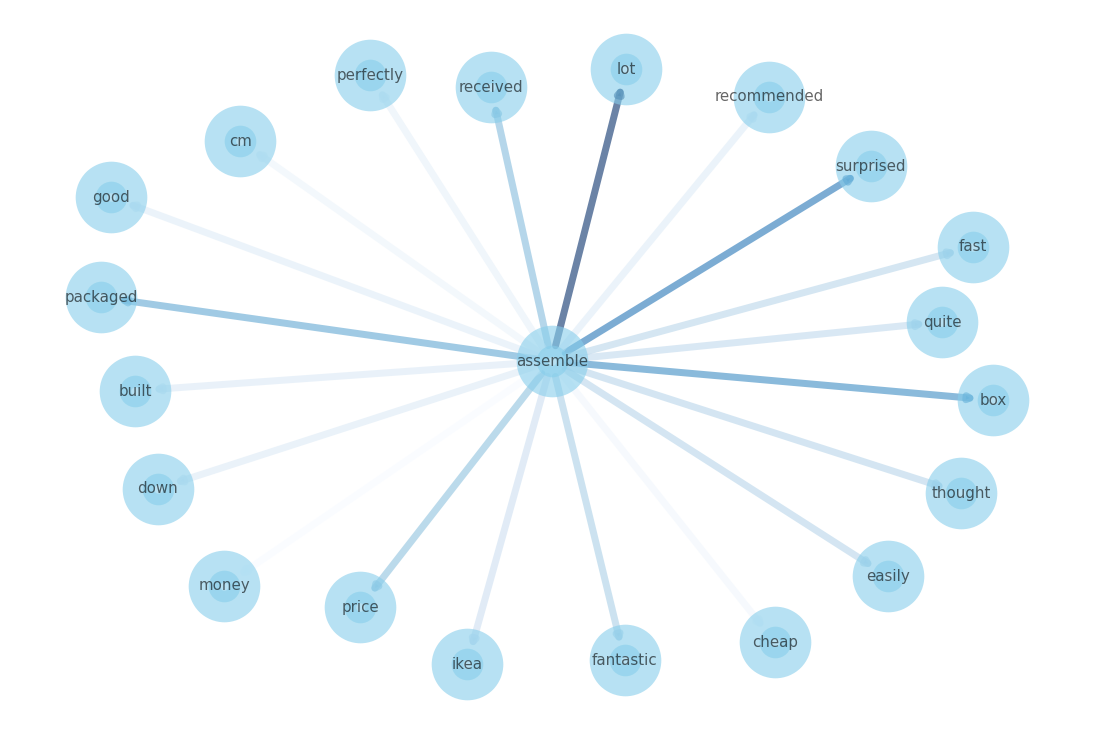

In [1946]:
# save_df.sort_values(['WORD','SG_SIMILARITY'],ascending=[True,False]).head(100)
plt.figure(figsize=(15, 10))
ss = save_df[save_df['WORD'].isin(['assemble'])].iloc[0:20]
g = nx.from_pandas_edgelist(ss, 'WORD', 'CBOW_WORDS', create_using = nx.DiGraph())
nx.draw(g, with_labels=True, node_color='skyblue',node_size=1000, alpha=0.6,edge_color=ss['CB_SIMILARITY'], width=7, edge_cmap=plt.cm.Blues,linewidths=40,font_size=15)
# nx.networkx.draw_networkx(g)
plt.show()

In [1951]:
eu_pos_df.category.unique()

array(['toppers', 'furniture', 'smartbases', 'platform beds',
       'foam mattresses/sets', 'frames for mattresses',
       'spring mattresses/sets'], dtype=object)

In [1997]:
w = 'unzip'
# c = 'toppers'
index_list  = eu_pos_df.index[(eu_pos_df['reviews'].str.contains(w,regex=True))].tolist()
review_list = eu_pos_df.loc[eu_pos_df.index.isin(index_list)].reviews.tolist()
sku_list = eu_pos_df.loc[eu_pos_df.index.isin(index_list)].sku.tolist()
cat_list = eu_pos_df.loc[eu_pos_df.index.isin(index_list)].category.tolist()
for i,v in enumerate(review_list):

    print(f'index : {i} / sku : {sku_list[i]} / category : {cat_list[i]} \n ■  values : {v}\n')

In [1673]:
# eu_pos_df[(eu_pos_df['category']=='furniture')].shape

# 
# eu_pos_df.shape

In [1656]:
eu_test_df[(eu_test_df['sentiment'] == 'positive')]

,brand,country,category,word,count,sentiment,cat_word_cnt,cat_word_diff,cat_all_word_cnt,cat_all_word_diff,country_all_count,cmpl_factor,review_count,all_review_cnt,review_rate
2473,ZINUS,de,toppers,quality,6,positive,30,20.00,1969,1.52,5156,NaN,5,16,31.25
2474,ZINUS,de,toppers,sleep,5,positive,29,17.24,1969,1.47,5156,NaN,4,16,25.00
2475,ZINUS,de,toppers,good,5,positive,35,14.29,1969,1.78,5156,NaN,4,16,25.00
2476,ZINUS,de,toppers,back,3,positive,29,10.34,1969,1.47,5156,NaN,3,16,18.75
2477,ZINUS,de,toppers,satisfied,3,positive,4,75.00,1969,0.20,5156,NaN,3,16,18.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13181,ZINUS,es,spring mattresses/sets,bought,1,positive,10,10.00,1830,0.55,4996,NaN,1,33,3.03
13182,ZINUS,es,spring mattresses/sets,comes,1,positive,3,33.33,1830,0.16,4996,NaN,1,33,3.03
13183,ZINUS,es,spring mattresses/sets,worry,1,positive,1,100.00,1830,0.05,4996,NaN,1,33,3.03
13184,ZINUS,es,spring mattresses/sets,grows,1,positive,1,100.00,1830,0.05,4996,NaN,1,33,3.03


In [733]:
# corpus = Corpus() 
# corpus.fit(pos_corpus_list, window=5)

# glove = Glove(no_components=200, learning_rate=0.05)
# glove.fit(corpus.matrix, epochs=20, no_threads=4, verbose=True)
# glove.add_dictionary(corpus.dictionary)

# glove.similar_by_vector('odor', topn=100, restrict_vocab=None)

import numpy as np

def loadGloveModel(File):
    print("Loading Glove Model")
    f = open(File,'r')
    gloveModel = {}
    for line in f:
        splitLines = line.split()
        word = splitLines[0]
        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        gloveModel[word] = wordEmbedding
    print(len(gloveModel)," words loaded!")
    return gloveModel

def find_closest_embeddings(embedding):
    return sorted(embedding.keys(), key=lambda word: spatial.distance.euclidean(embedding[word], embedding))


print(glove.dictionary.items())

# print(glove.word_vectors[0])

dict_items([('sleep', 0), ('quality', 1), ('adapts', 2), ('body', 3), ('met', 4), ('expectations', 5), ('impressive', 6), ('form', 7), ('memory', 8), ('material', 9), ('happy', 10), ('purchase', 11), ('perfect', 12), ('comfortable', 13), ('sofa', 14), ('week', 15), ('unbearably', 16), ('hard', 17), ('efficient', 18), ('slept', 19), ('putting', 20), ('true', 21), ('smells', 22), ('bad', 23), ('downside', 24), ('price', 25), ('costs', 26), ('photo', 27), ('highly', 28), ('recommended', 29), ('great', 30), ('purchased', 31), ('cm', 32), ('version', 33), ('use', 34), ('top', 35), ('old', 36), ('pirelli', 37), ('latex', 38), ('hardened', 39), ('time', 40), ('observations', 41), ('appearance', 42), ('texture', 43), ('similar', 44), ('feather', 45), ('rubber', 46), ('works', 47), ('makes', 48), ('soft', 49), ('present', 50), ('sinking', 51), ('trend', 52), ('right', 53), ('giving', 54), ('too', 55), ('difficulty', 56), ('movement', 57), ('personally', 58), ('depends', 59), ('personal', 60), (

TypeError: 'Glove' object is not subscriptable

In [948]:
# glove.save('model/eu_positive_glove_model.bin')
#save Glove model 
with open("model/results_glove.txt", "w") as f:
    for word in glove.dictionary:
        f.write(word)
        f.write(" ")
        for i in range(0, 200):
            f.write(str(glove.word_vectors[glove.dictionary[word]][i]))
            f.write(" ")
        f.write("\n")
    

#convert to glove2word2vec
# glove2word2vec(glove_input_file=open('model/eu_positive_glove_model.bin'), word2vec_output_file="model/text.txt")    

#load Glove Model
# model = KeyedVectors.load_word2vec_format("model/text.txt", binary=False)

In [947]:
# glove_dic_word = list(glove.inverse_dictionary.values())

ss = open('model/results_glove.txt')

type(ss)

_io.TextIOWrapper

# EU - WordCloud

In [905]:
test_df = test_df[~test_df['word'].isin(stop_words)]
test_df['rank'] = test_df.groupby(['country','sentiment'])['review_rate'].rank(method='first',ascending=False).astype(int)
test_df = test_df.sort_values(['country','sentiment','rank'],ascending=[True,True,True])
test_df = test_df[test_df['rank'] <= 300]

In [1815]:
import requests
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
from io import BytesIO 

def read_img_from_url_and_return_matrix(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img_matrix = np.array(img)
    return img_matrix


def make_colors(word,font_size,position,orientation,random_state,**kwargs):
    r = random_state.randint(0,105)
    g = random_state.randint(82,155)
    b = random_state.randint(33,103)    
    
    color = f'rgb({r},{g},{b})'
    
    return color

def make_ImageColoredWordcloud(text, img_matrix, outputfile_name,color):
    wc = WordCloud(width = 800, height = 800,background_color="white",
                   max_words=3000, mask=img_matrix, min_font_size=4, 
                   max_font_size=80, random_state=42,stopwords=stop_words,
                  relative_scaling =0,colormap=color)
#     ,colormap=color

    # generate word cloud
#     wc.generate(text)
    wc.generate_from_frequencies(text)
    print(make_colors)
    wc.recolor(color_func=make_colors,random_state=True)
    f = plt.figure(figsize=(20, 20))

#     plt.imshow(wc.recolor(color_func=ImageColorGenerator(img_matrix)), interpolation="bilinear")
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(outputfile_name)


In [1870]:
eu_keyword_pos.head

<bound method NDFrame.head of           word  count
0       14inch     12
1     14inches      6
2          1st     18
3        200lb      6
4         2020      6
...        ...    ...
8856   zoomies      6
8857     zowee      6
8858       zzz     12
8859     zzzzz      6
8860    zzzzzz      6

[8861 rows x 2 columns]>

In [476]:
color_list = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']

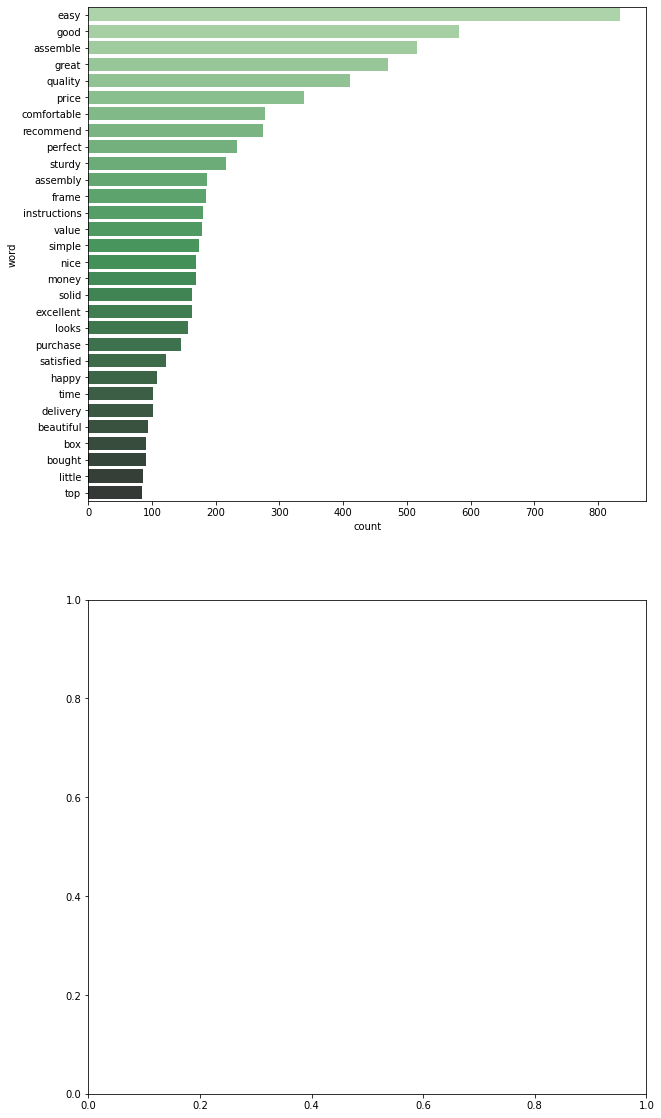

In [1893]:
eu_neeg_keyword = pd.read_csv('eu_pos_keyword.csv')
eu_neeg_keyword
fig, axes = plt.subplots(2,1,figsize=(10,20))
ax = sns.barplot(ax=axes[0],x='count',y='word',data=eu_neeg_keyword.sort_values('count',ascending = False).head(30),palette='Greens_d')
# for index, row in eu_keyword_pos.sort_values('count',ascending = False).head(30).reset_index().iterrows():
#     ax.text(row.index,row.count,row.word, color='black', ha="center")
# test_df[(test_df['sentiment'] == 'negative')&(~test_df['word'].isin(['good','comfortable']))].groupby(['word'])['count'].sum().reset_index().sort_values('count',ascending = False).head(30)

In [1468]:
eu_keyword_pos.sort_values('count',ascending = False).head(30).reset_index()

,index,word,count
0,115,easy,834
1,170,good,582
2,24,assemble,516
3,172,great,470
4,313,quality,411
5,302,price,338
6,71,comfortable,277
7,324,recommend,274
8,285,perfect,233
9,386,sturdy,216


<function make_colors at 0x7f79d29368b0>


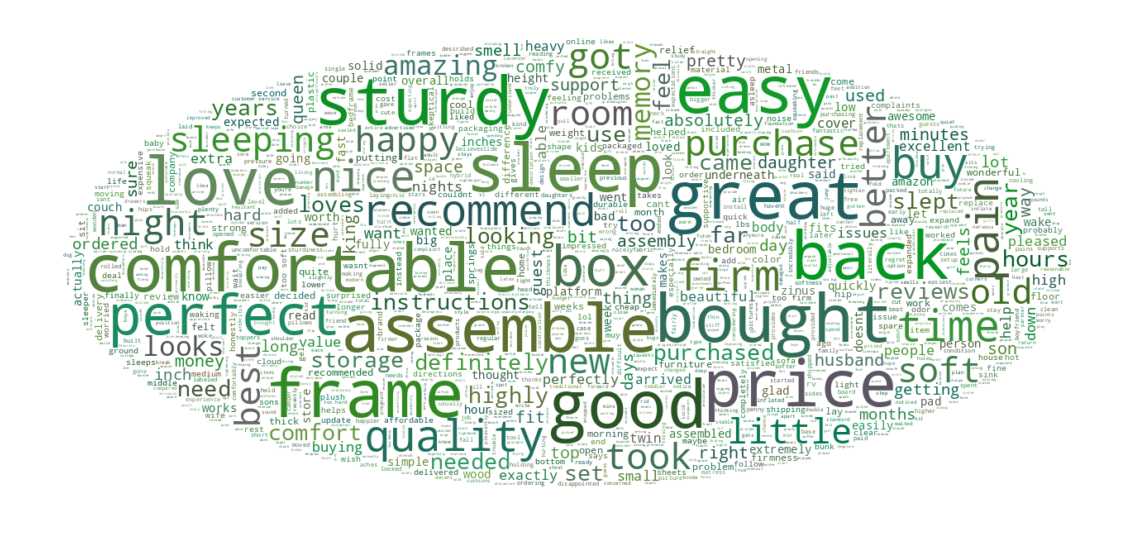

In [1816]:
url        = "temp/img/circle3.png"
img_matrix = np.array(Image.open(url))
# eu_keyword_pos = test_df[(test_df['sentiment'] == 'positive') ]
eu_keyword_pos = test_df[(test_df['sentiment'] == 'positive') ].groupby(['word'])['count'].sum().reset_index()
pos_text       = pd.Series(eu_keyword_pos['count'].values,index=eu_keyword_pos.word).to_dict()

make_ImageColoredWordcloud(pos_text, img_matrix, 'temp/img/coloredWordCloud.png','Greens')
# eu_keyword_pos.sort_values('').head(50)

In [917]:
test_df[(test_df['sentiment'] == 'positive') ].groupby(['word'])['count'].sum().reset_index().sort_values('count',ascending=False).to_csv('eu_pos_keyword.csv',index=0)

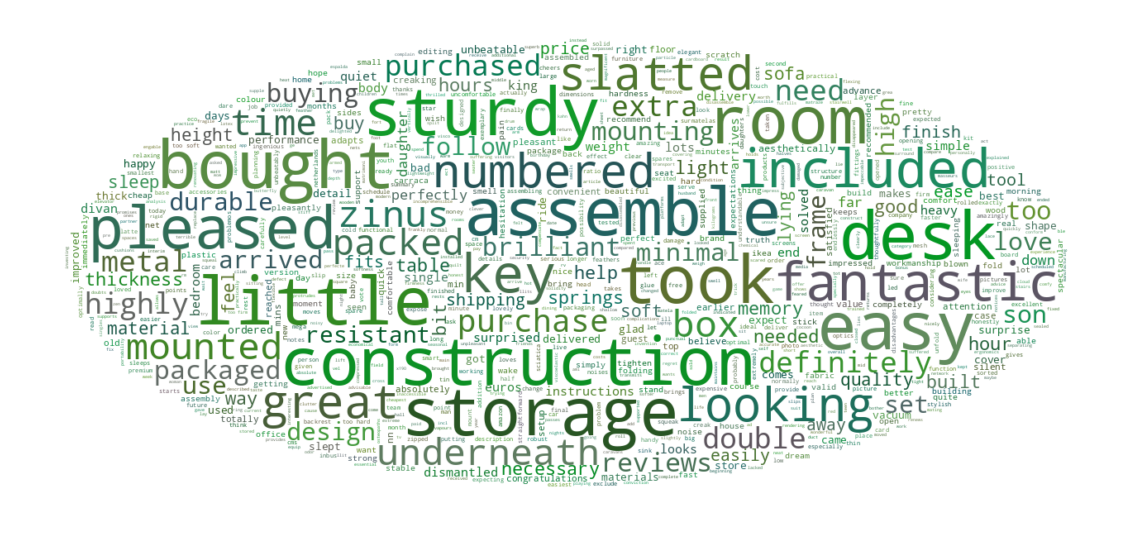

In [904]:
url        = "temp/img/circle3.png"
img_matrix = np.array(Image.open(url))
eu_keyword_pos = test_df[(test_df['sentiment'] == 'positive') ]
# eu_keyword_pos = test_df[(test_df['sentiment'] == 'positive') ].groupby(['word'])['count'].sum().reset_index()
pos_text       = pd.Series(eu_keyword_pos['count'].values,index=eu_keyword_pos.word).to_dict()

make_ImageColoredWordcloud(pos_text, img_matrix, 'temp/img/coloredWordCloud.png','Greens')
# eu_keyword_pos.sort_values('').head(50)

In [899]:
test_df[(test_df['sentiment'] == 'positive') ].groupby(['word'])['count'].sum().reset_index().sort_values('count',ascending=False).head(50)

,word,count
185,easy,834
275,good,586
37,assemble,529
278,great,489
521,quality,411
506,price,341
113,comfortable,296
536,recommend,274
474,perfect,236
654,sturdy,216


<function make_colors at 0x7f79d29368b0>


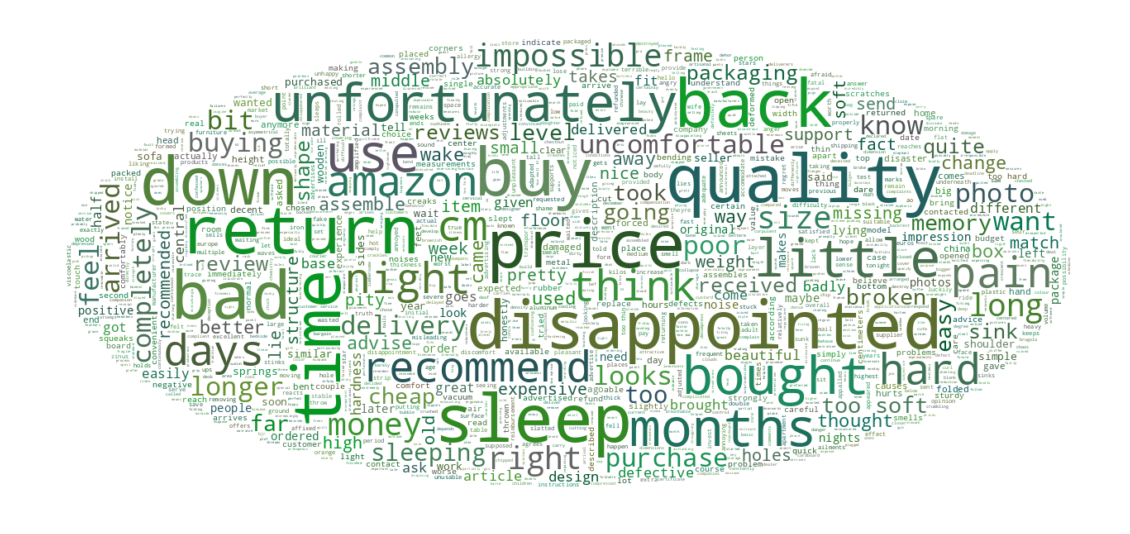

In [1848]:
url        = "temp/img/circle3.png"
img_matrix = np.array(Image.open(url))
eu_keyword_neg = eu_test_df[(eu_test_df['sentiment'] == 'negative')&(~eu_test_df['word'].isin(['good','comfortable']))].groupby(['word'])['count'].count().reset_index()
neg_text       = pd.Series(eu_keyword_neg['count'].values,index=eu_keyword_neg.word).to_dict()

make_ImageColoredWordcloud(neg_text, img_matrix, 'temp/img/coloredWordCloud.png','Greens')

In [1850]:
eu_keyword_neg.sort_values('count',ascending=False)

,word,count
72,back,19
846,quality,18
1011,sleep,13
310,down,13
903,return,13
...,...,...
708,ner,1
709,net,1
710,networks,1
277,desk,1


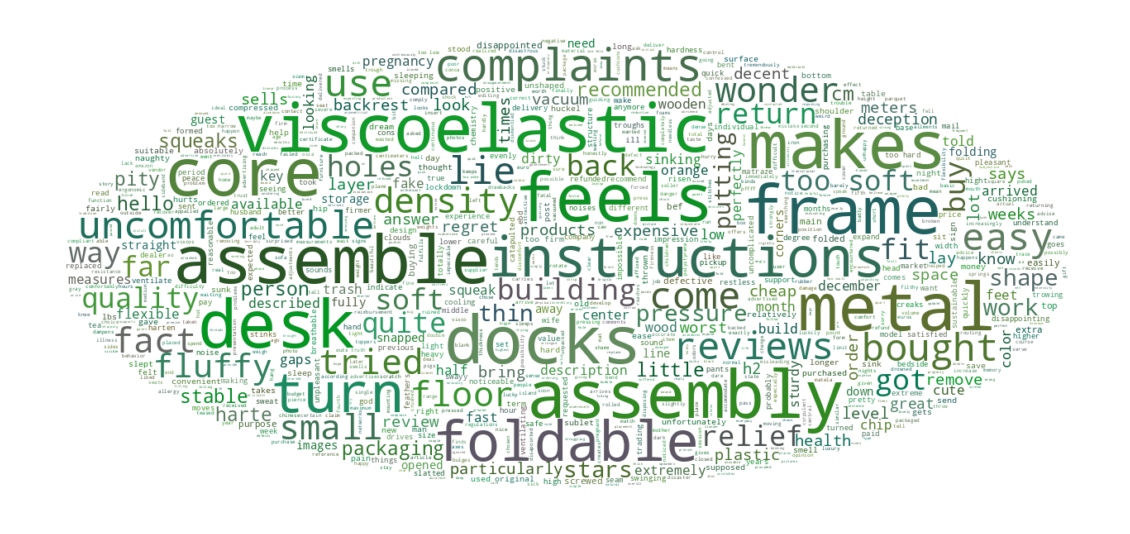

In [910]:
url        = "temp/img/circle3.png"
img_matrix = np.array(Image.open(url))
eu_keyword_neg = test_df[(test_df['sentiment'] == 'negative')&(~test_df['word'].isin(['good','comfortable']))]
neg_text       = pd.Series(eu_keyword_neg['count'].values,index=eu_keyword_neg.word).to_dict()

make_ImageColoredWordcloud(neg_text, img_matrix, 'temp/img/coloredWordCloud.png','Greens')

In [916]:
eu_keyword_neg.sort_values('count',ascending=False).to_csv('eu_neg_keyword.csv',index=0)

In [666]:
eu_keyword_pos.groupby(['word'])['count'].sum().reset_index().sort_values('count',ascending=False)[0:30].to_csv('temp/all_eu_pos_keyword.csv',index=0)
eu_keyword_neg.groupby(['word'])['count'].sum().reset_index().sort_values('count',ascending=False)[0:30].to_csv('temp/all_eu_neg_keyword.csv',index=0)